In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
fetch_20newsgroups

<function sklearn.datasets._twenty_newsgroups.fetch_20newsgroups(data_home=None, subset='train', categories=None, shuffle=True, random_state=42, remove=(), download_if_missing=True, return_X_y=False)>

In [5]:
newsgroups_train.filenames.shape, newsgroups_test.target.shape

((2034,), (1353,))

In [6]:
print('\n'.join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [7]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [8]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [9]:
num_topics, num_top_words = 6, 8

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [12]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [13]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(26576,)

In [14]:
vocab[7000:7020]


array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

In [15]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 3min 7s, sys: 5.24 s, total: 3min 12s
Wall time: 2min 1s


In [16]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


### conformation of decompostion of input 

In [ ]:
reconstructed_vectors = U @ np.diag(s) @ Vh
np.linalg.norm(reconstructed_vectors - vectors)
np.allclose(reconstructed_vectors, vectors)

## showing U and Vh orthonormal

In [17]:
np.allclose(U.T @ U, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

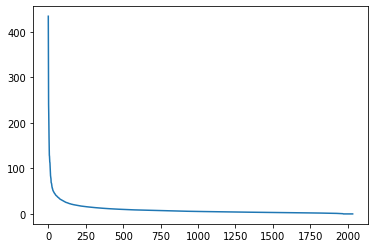

In [18]:
plt.plot(s)

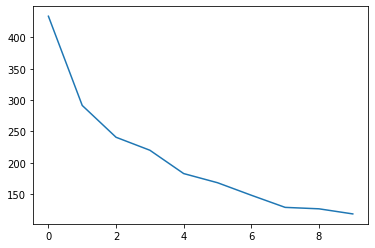

In [19]:
plt.plot(s[:10])

In [20]:
num_top_words = 8


In [21]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [22]:
show_topics(Vh[:5])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

## NMF from sklearn

In [23]:
m ,n = vectors.shape
d=5

In [24]:
clf = decomposition.NMF(n_components=d, random_state=1)

In [25]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [26]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

# TF-IDF

In [27]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [28]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [29]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

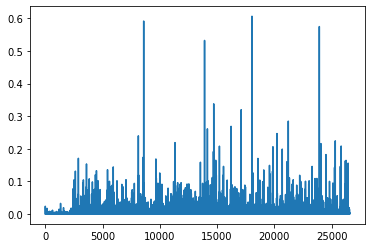

In [30]:
plt.plot(clf.components_[0])

In [31]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

In [32]:
clf.reconstruction_err_

43.7129260579529

In [33]:
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

In [34]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [35]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [36]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [37]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

In [38]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [39]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [40]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [41]:
report(vectors_tfidf, W, H)

44.42694479845535 2.945949884816668e-07 2.115634419653764e-08 0 0


In [42]:
upd(vectors_tfidf,W,H,lr)

In [43]:
report(vectors_tfidf, W, H)

44.418976834528806 -0.0008285428879699698 -7.992478764010872e-05 151 293


In [44]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.413148447229794 -0.0007402393462001848 -6.597962054453392e-05 118 292
44.374879412622924 -0.0002883900915530287 -6.067883652312768e-05 53 516
44.346174433515785 -0.00024283644575548338 -6.152051154125266e-05 37 1002
44.31426497091786 -0.0001332280826534442 -8.146649077453277e-05 38 1602
44.27922792868162 -8.468703903074837e-05 -9.709118372008606e-05 22 2332


## `Torch`

In [45]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In [46]:
def V(M): return Variable(M, requires_grad=True)

In [47]:
v=vectors_tfidf.todense()

In [48]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [49]:
mu = 1e-5

In [50]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(torch.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [51]:
t_W = torch.FloatTensor(m,d)
t_H = torch.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [52]:
d=6; lam=100; lr=0.05

In [53]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9

tensor(44.3443) tensor(-0.0044) tensor(-0.0005) tensor(828) tensor(1359)
tensor(43.7017) tensor(-0.0085) tensor(-0.0137) tensor(1695) tensor(19463)
tensor(43.6524) tensor(-0.0068) tensor(-0.0062) tensor(1596) tensor(17965)
tensor(43.6252) tensor(-0.0082) tensor(-0.0083) tensor(1766) tensor(16808)
tensor(43.6180) tensor(-0.0052) tensor(-0.0057) tensor(1848) tensor(16970)
tensor(43.6162) tensor(-0.0037) tensor(-0.0098) tensor(2327) tensor(18617)
tensor(43.6159) tensor(-0.0053) tensor(-0.0049) tensor(2594) tensor(19541)
tensor(43.6158) tensor(-0.0041) tensor(-0.0074) tensor(2432) tensor(20769)
tensor(43.6158) tensor(-0.0036) tensor(-0.0071) tensor(2374) tensor(20845)
tensor(43.6157) tensor(-0.0041) tensor(-0.0065) tensor(3084) tensor(26124)


In [54]:
show_topics(t_H.cpu().numpy())

['graphics thanks files image file program windows know',
 'people don think just like objective say morality',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'space nasa launch shuttle orbit moon lunar earth',
 'god jesus bible believe christian atheism does belief']

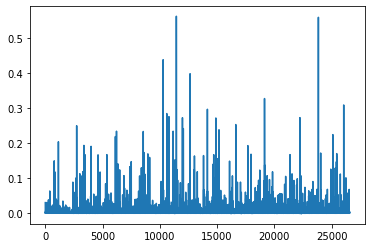

In [55]:
plt.plot(t_H.cpu().numpy()[0])

In [56]:
t_W.mm(t_H).max()

tensor(0.3977)

In [57]:
t_vectors.max()

tensor(1.)

## pytorch autograd

In [58]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [59]:
print(x.data)

tensor([[1., 1.],
        [1., 1.]])


In [60]:
print(x.grad)

None


In [61]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [62]:
z = y * y * 3
out = z.sum()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(108., grad_fn=<SumBackward0>)


In [63]:
out.backward()
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])
